# 0. Libraries.

In [1]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms
import numpy as np
from matplotlib import pyplot as plt
import operator as op

print('Setup completed.')

Setup completed.


# 1. Loading MNIST dataset.

In [2]:
# hardcode.
MNIST_mean = 0.1307
MNIST_std = 0.3081

transform = transforms.Compose([
    transforms.ToTensor(), # converts digit's image to a (1, 28, 28) tensor pixel-by-pixel.
    transforms.Normalize((MNIST_mean,), (MNIST_std,)), # normalizes (1, 28, 28) tensor. 
    transforms.Lambda(lambda x: x.view(-1)) # reshapes (1, 28, 28) tensor to (784,) tensor.
])

In [3]:
train = datasets.MNIST(
    root='./data/',
    download=True,
    train=True,
    transform=transform
)
test = datasets.MNIST(
    root='./data/',
    download=True,
    train=False,
    transform=transform
)
print('Datasets loaded successfully.')

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.44MB/s]

Datasets loaded successfully.


# 2. Researching some data's PRIKOLЫ)

### 2.1. Displaying several handwritten digits.

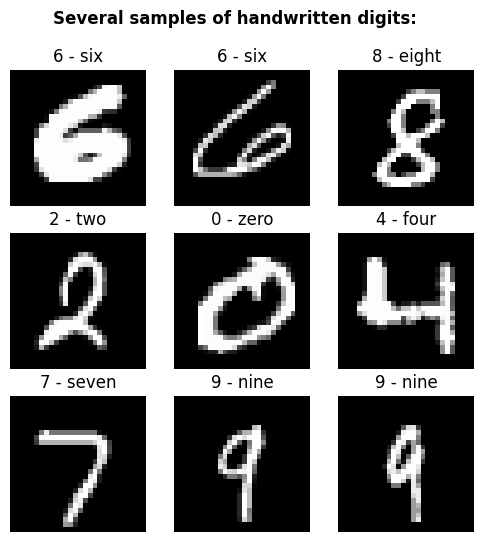

In [4]:
# this cell's code was mostly taken from this notebook:
# https://www.kaggle.com/code/faduregis/computer-vision-with-pytorch-using-mnist-dataset

torch.manual_seed(42)

fig = plt.figure(figsize=(6, 6))
fig.suptitle('Several samples of handwritten digits:', fontweight='bold')
rows, cols = 3, 3
for i in range(rows * cols):
    index = torch.randint(len(train), size=(1,)).item()
    image, label = train[index]
    image = image.reshape(28, 28)
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(train.classes[label])
    plt.axis(False)
fig.show()

### 2.2. Plotting distribution of images by digits written on them.

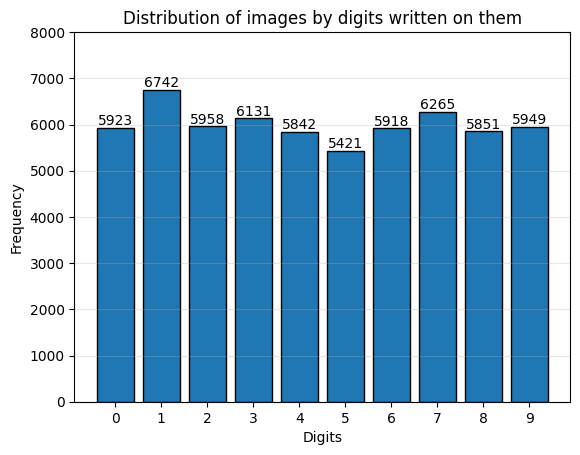

In [5]:
classes, counts = train.targets.unique(return_counts=True)
x = plt.bar(
    classes,
    counts,
    edgecolor='black',
    tick_label=classes
)
plt.bar_label(x)
plt.grid(axis='y', alpha=0.3)
plt.title('Distribution of images by digits written on them')
plt.xlabel('Digits')
plt.ylabel('Frequency')
plt.ylim(0, 8_000)
plt.show()

#### [!] This one code cell below will help us in my hypothesis (I haven't written about it yet) a little bit later...

In [6]:
classes = [c.item() for c in classes]
counts = [c.item() for c in counts]
paired = list(zip(classes, counts))
paired.sort(key=op.itemgetter(1))
digits_sorted_by_frequency = [digit for digit, _ in paired]
print(f'Digits sorted by their frequency (in ascending order): {digits_sorted_by_frequency}.')

Digits sorted by their frequency (in ascending order): [5, 4, 8, 6, 0, 9, 2, 3, 7, 1].


### 2.3. Getting mean image for each of digits (for each digit I calculate every pixel's mean value and display result on the screen);
### 2.4. Calculaing mean pixel's standard deviation (further - MPSD) for each digit; detecting digits with the smallest and the biggest values of MPSD.
##### P.S.: ChatGPT's ideas, my (with help by ChatGPT, of course) realizations.

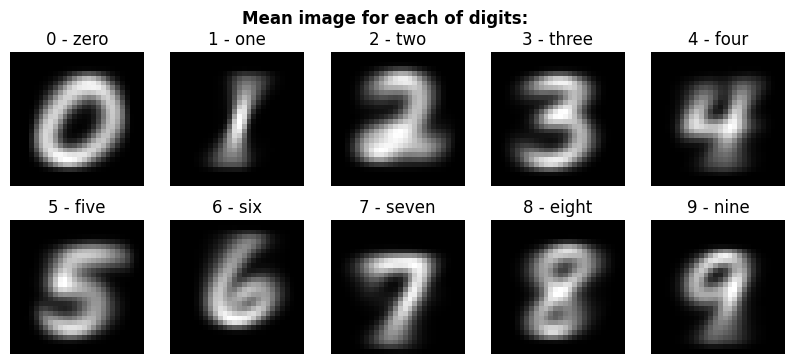

MPSDs for each digit:
0 - 0.572236
1 - 0.307724
2 - 0.599240
3 - 0.549594
4 - 0.519821
5 - 0.570436
6 - 0.519783
7 - 0.483978
8 - 0.544318
9 - 0.482412
Digit with the minimal MPSD: 1.
Digit with the maximal MPSD: 2.


In [7]:
MPSDs = []

fig = plt.figure(figsize=(10, 4))
fig.suptitle('Mean image for each of digits:', fontweight='bold')
rows, cols = 2, 5
for digit in range(10):
    mask = train.targets == digit
    indexes = mask.nonzero(as_tuple=True)[0]
    subset = Subset(train, indexes)
    images = torch.stack([t[0] for t in subset])
    
    mean_image = images.mean(dim=0).reshape(28, 28)
    fig.add_subplot(rows, cols, digit + 1)
    plt.imshow(mean_image.squeeze(), cmap='gray')
    plt.title(train.classes[digit])
    plt.axis(False)

    MPSDs.append(images.std(dim=0).mean())
plt.show()

print('MPSDs for each digit:')
for digit in range(10):
    print(f'{digit} - {MPSDs[digit]:.6f}')
print(f'Digit with the minimal MPSD: {torch.tensor(MPSDs).argmin()}.')
print(f'Digit with the maximal MPSD: {torch.tensor(MPSDs).argmax()}.')

#### [!] Code cell below is the second one, which will be required afterwards.

In [8]:
paired = list(zip(range(10), MPSDs))
paired.sort(key=op.itemgetter(1))
digits_sorted_by_MPSD = [digit for digit, _ in paired]
print(f'Digits sorted by their MPSD (in ascending order): {digits_sorted_by_MPSD}.')

Digits sorted by their MPSD (in ascending order): [1, 9, 7, 6, 4, 8, 3, 5, 0, 2].


### 2.5. My hypotesis.

In [9]:
direct_correlation = np.corrcoef(
    digits_sorted_by_frequency,
    digits_sorted_by_MPSD
)[0][1]
reverse_correlation = np.corrcoef(
    digits_sorted_by_frequency,
    digits_sorted_by_MPSD[::-1]
)[0][1]
print(f'''
Correlations between two orders of digits:
1) Sorted by their frequency;
2) Sorted by their MPSD.

Direct correlation (both orders are ascending) = {direct_correlation:.3f};
Reverse correlation (one order is ascending, another one is descending) = {reverse_correlation:.3f}.
''')


Correlations between two orders of digits:
1) Sorted by their frequency;
2) Sorted by their MPSD.

Direct correlation (both orders are ascending) = 0.309;
Reverse correlation (one order is ascending, another one is descending) = -0.018.



### My hypotesis was the next:
### "_Let's consider one certain digit. Then the power of how strong images of this digit differ from each other (in our case, metric of this 'difference power' was MPSD) depends on how many images of this digit we have._"
### This thought came in my mind because digit 1 has the biggest images number of it and the the smallest MPSD. However, correlation coefficient's absolute value isn't so big, hence my hypotesis isn't truthful and the fun fact about digit 1 is caused only by that people often write digit 1 just as a single stick which is really simple geometric object, so this digit's MPSD is such a small - only about 0.3.
### :)

# 3. Creating a DataLoader.

In [10]:
BATCH_SIZE = 256

train_DL = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_DL = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print('Both DataLoader\'s have been successfully created.')

Both DataLoader's have been successfully created.


In [11]:
batch_example = next(iter(train_DL))
print(batch_example[0].shape) # (BATCH_SIZE) images.
print(batch_example[1].shape) # (BATCH_SIZE) labels.

torch.Size([256, 784])
torch.Size([256])


# 4. Creating a model.

In [12]:
class ThreeLayerPerceptron(nn.Module):
    def __init__(self,
                 inputlayer_size:   int,
                 hiddenlayer1_size: int,
                 hiddenlayer2_size: int,
                 hiddenlayer3_size: int,
                 outputlayer_size:  int) -> None:
        
        super().__init__() # calling the constructor of nn.Module class (the parent class).

        # defining connections between model's layers ('fc' stands for 'fully connected').
        self.fc1 = nn.Linear(inputlayer_size, hiddenlayer1_size)
        self.fc2 = nn.Linear(hiddenlayer1_size, hiddenlayer2_size)
        self.fc3 = nn.Linear(hiddenlayer2_size, hiddenlayer3_size)
        self.out = nn.Linear(hiddenlayer3_size, outputlayer_size)

        return

    def forward(self,
                x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        # we don't apply Softmax function to output layer's values
        # because our loss function will be CrossEntropyLoss
        # which will apply Softmax by itself.
        return x

print('\'ThreeLayerPerceptron\' class has been successfully defined.')

'ThreeLayerPerceptron' class has been successfully defined.


In [13]:
# if it's possible, we will train our model on GPU (CUDA), else - on CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [14]:
model = ThreeLayerPerceptron(28 ** 2, 256, 128, 64, 10).to(device) # the model itself.
criterion = nn.CrossEntropyLoss() # loss function (idk how it calculates, but ChatGPT says it's ok).
optimizer = optim.Adam(model.parameters(), lr=1e-3) # idk what it is at all, but, again, ChatGPT says it's ok.
print('Everything is fine)')

Everything is fine)


# 5. Training loop.

In [15]:
# hardcode.
EPOCHS = 20

LALA = [] # train_Loss, train_Acc, test_Loss, test_Acc.
for epoch in range(EPOCHS):
    
    model.train() # turning on training mode.
    total_loss = 0 # sum of losses for each sample.
    correct = 0 # number of correct predictions.
    for x, y in train_DL:
        x, y = x.to(device), y.to(device) # moving both input and output tensors to the GPU (mostly).
        optimizer.zero_grad() # clearing previous gradients.

        logits = model(x) # outputs of the model when x is moved to the input.
        loss = criterion(logits, y) # value of loss function.
        loss.backward() # backpropagation and calculating gradients.
        optimizer.step() # updating model's weights.

        total_loss += loss.item() * len(y)
        # we have to multiply our loss by len(y) (current batch's size
        # which is usually equals to BATCH_SIZE excepting, maybe, the last batch)
        # because loss.item() is the average loss among all samples in current batch.
        correct += (logits.argmax(1) == y).sum().item()
    train_loss = total_loss / len(train)
    train_acc = correct / len(train) # 'acc' stands for 'accuracy'.

    model.eval() # turning on evaluation mode.
    total_loss = correct = 0
    with torch.no_grad(): # in this block gradients won't be calculated for any operation on the model.
        for x, y in test_DL:
            x, y = x.to(device), y.to(device)
    
            logits = model(x)
            loss = criterion(logits, y)
    
            total_loss += loss.item() * len(y)
            correct += (logits.argmax(1) == y).sum().item()
    test_loss = total_loss / len(test)
    test_acc = correct / len(test)

    print(f'Epoch {epoch + 1:02d}: '
          f'Train loss {train_loss:.4f}, acc {train_acc:.4f} | '
          f'Test loss {test_loss:.4f}, acc {test_acc:.4f}')
    LALA.append((train_loss, train_acc, test_loss, test_acc))

Epoch 01: Train loss 0.3950, acc 0.8879 | Test loss 0.1750, acc 0.9463
Epoch 02: Train loss 0.1413, acc 0.9577 | Test loss 0.1271, acc 0.9605
Epoch 03: Train loss 0.0971, acc 0.9704 | Test loss 0.1053, acc 0.9667
Epoch 04: Train loss 0.0706, acc 0.9784 | Test loss 0.0897, acc 0.9707
Epoch 05: Train loss 0.0586, acc 0.9813 | Test loss 0.0852, acc 0.9743
Epoch 06: Train loss 0.0432, acc 0.9867 | Test loss 0.0731, acc 0.9774
Epoch 07: Train loss 0.0348, acc 0.9884 | Test loss 0.0747, acc 0.9774
Epoch 08: Train loss 0.0292, acc 0.9908 | Test loss 0.0684, acc 0.9792
Epoch 09: Train loss 0.0211, acc 0.9932 | Test loss 0.0781, acc 0.9783
Epoch 10: Train loss 0.0203, acc 0.9932 | Test loss 0.0745, acc 0.9791
Epoch 11: Train loss 0.0156, acc 0.9948 | Test loss 0.0697, acc 0.9819
Epoch 12: Train loss 0.0139, acc 0.9953 | Test loss 0.0794, acc 0.9793
Epoch 13: Train loss 0.0130, acc 0.9957 | Test loss 0.0917, acc 0.9776
Epoch 14: Train loss 0.0156, acc 0.9949 | Test loss 0.0879, acc 0.9774
Epoch 

# 6. Plots of LALA.

In [16]:
LALA = torch.tensor(LALA)
LALA

tensor([[0.3950, 0.8879, 0.1750, 0.9463],
        [0.1413, 0.9577, 0.1271, 0.9605],
        [0.0971, 0.9704, 0.1053, 0.9667],
        [0.0706, 0.9784, 0.0897, 0.9707],
        [0.0586, 0.9813, 0.0852, 0.9743],
        [0.0432, 0.9867, 0.0731, 0.9774],
        [0.0348, 0.9884, 0.0747, 0.9774],
        [0.0292, 0.9908, 0.0684, 0.9792],
        [0.0211, 0.9932, 0.0781, 0.9783],
        [0.0203, 0.9932, 0.0745, 0.9791],
        [0.0156, 0.9948, 0.0697, 0.9819],
        [0.0139, 0.9953, 0.0794, 0.9793],
        [0.0130, 0.9956, 0.0917, 0.9776],
        [0.0156, 0.9949, 0.0879, 0.9774],
        [0.0127, 0.9957, 0.0948, 0.9791],
        [0.0110, 0.9962, 0.0857, 0.9808],
        [0.0083, 0.9974, 0.0807, 0.9820],
        [0.0115, 0.9962, 0.0866, 0.9810],
        [0.0106, 0.9966, 0.1030, 0.9779],
        [0.0091, 0.9968, 0.1028, 0.9801]])

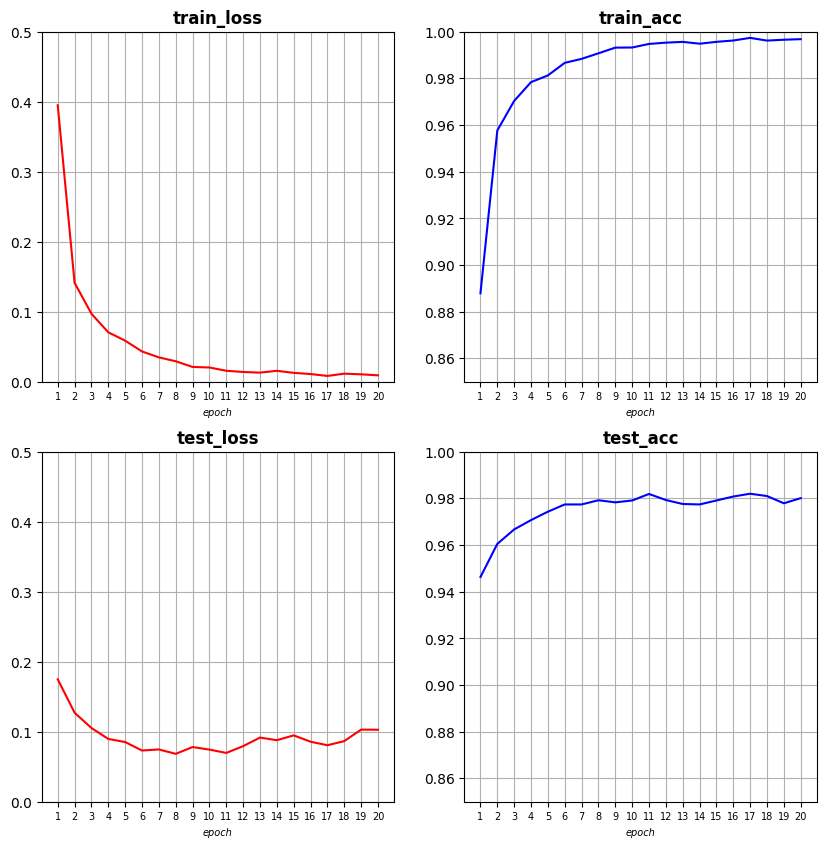

In [17]:
x = list(range(1, EPOCHS + 1))
plot_names = ['train_loss', 'train_acc', 'test_loss', 'test_acc']

fig = plt.figure(figsize=(10, 10))
rows, cols = 2, 2
for i in range(4):
    fig.add_subplot(rows, cols, i + 1)
    plt.plot(x, LALA[:, i], color = 'red' if i % 2 == 0 else 'blue')
    plt.xticks(x, fontsize=7)
    plt.xlabel('epoch', fontsize=7, fontstyle='italic')
    if i % 2 == 0:
        plt.ylim(0, .5)
    else:
        plt.ylim(.85, 1)
    plt.title(plot_names[i], fontweight='bold')
    plt.grid(True)
fig.show()

### I like that only 1 epoch of training already results a 95% accuracy on test dataset)

# 7. Displaying several misclassifications.
##### P.S.: this idea was taken from this notebook: https://www.kaggle.com/code/tahmidmir/hand-written-digit-recognition-using-mnist-dataset

In [18]:
N = 9 # how many misclassifications to display. 9 = 3x3.

model.eval()
test_outputs = []
test_labels = []
with torch.no_grad():
    for x, y in test_DL:
        x = x.to(device)
        logits = model(x).argmax(1)
        test_outputs.append(logits.cpu())

        test_labels.append(y)
test_outputs = torch.cat(test_outputs)
test_labels = torch.cat(test_labels)

In [19]:
mask = test_outputs != test_labels
print(f'Total misclassifications for the test dataset: {mask.sum()}.')

Total misclassifications for the test dataset: 199.


In [20]:
indexes = mask.nonzero(as_tuple=True)[0]
indexes = indexes[:N]
indexes

tensor([115, 247, 274, 321, 340, 381, 445, 447, 495])

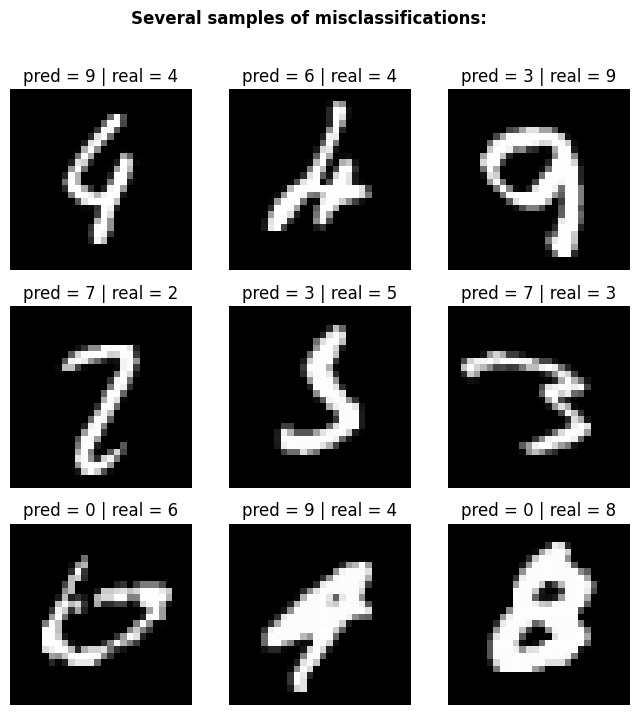

In [21]:
fig = plt.figure(figsize=(8, 8))
fig.suptitle('Several samples of misclassifications:', fontweight='bold')
rows, cols = 3, 3
for i in range(rows * cols):
    index = indexes[i]
    image, label = test[index]
    image = image.reshape(28, 28)
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f'pred = {test_outputs[index]} | real = {test_labels[index]}')
    plt.axis(False)
fig.show()

# 8. Conclusion.
### This notebook is the first one where I've teached a neural network. It was hard to work with new framework but I did it.
### I think that in my future works I have to learn and apply some regularization techniques ('early stopping' and/or 'dropout') because on the plots we can observe that on the last epochs **test_loss** has grown a little bit and **test_acc** has reduced a little bit.

# The end! ;)